These are the pre-photometry steps required to align to Gaia, drizzle together and update the original image DQ extension for CR found during drizzling.

reference notebook:
https://spacetelescope.github.io/notebooks/notebooks/DrizzlePac/align_to_catalogs/align_to_catalogs.html

requirements: astroconda::drizzlepac

In [1]:
# imports
import astropy.units as u
import glob
import numpy as np
import matplotlib.pyplot as plt
import os,shutil

from astropy.io import fits
from astropy.table import Table
from astropy.units import Quantity
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
# from astroquery.mast import Observations
# from astroquery.sdss import SDSS

from ccdproc import ImageFileCollection
from IPython.display import Image

from drizzlepac import tweakreg
from drizzlepac import astrodrizzle

Created TAP+ (v20200428.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v20200428.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


In [2]:
# control what to work on

region="off"
filt="f160w"

# autoset catalog path based on user
if os.environ['USER'] =='remy':
    workdir="/Users/remy/cv/magellanic/n159/"
    
    
os.chdir(workdir+region+"/"+filt+"/")

if filt=="f125w" or filt=="f160w":
    kind="flt"
    camera="IR"
else:
    kind="flc"
    camera="UVO"

In [3]:
collec = ImageFileCollection("./", glob_include="*"+kind+".fits", ext=0,
                             keywords=["targname", "ra_targ", "dec_targ", "filter", "exptime", "postarg1", "postarg2"])

table = collec.summary
table['exptime'].format = '7.1f'
table['ra_targ'].format = '7.7f'
table['dec_targ'].format = '7.7f'
table['postarg1'].format = '7.2f'
table['postarg2'].format = '7.2f'
table

file,targname,ra_targ,dec_targ,filter,exptime,postarg1,postarg2
str18,str9,float64,float64,str5,float64,float64,float64
icbna6jaq_flt.fits,OFF-POINT,85.2508983,-69.8056833,F160W,399.2,5.55,2.47
icbna6jgq_flt.fits,OFF-POINT,85.2508983,-69.8056833,F160W,399.2,5.55,2.47
icbna6jjq_flt.fits,OFF-POINT,85.2508983,-69.8056833,F160W,399.2,5.71,1.94
icbna6jqq_flt.fits,OFF-POINT,85.2508983,-69.8056833,F160W,299.2,5.74,3.00


In [4]:
# Gaia query
RA = table['ra_targ'][0]
Dec = table['dec_targ'][0]

coord = SkyCoord(ra=RA, dec=Dec, unit=(u.deg, u.deg))
radius = Quantity(3., u.arcmin)

gaia_query = Gaia.query_object_async(coordinate=coord, radius=radius)
reduced_query = gaia_query['ra', 'dec', 'phot_g_mean_mag']
reduced_query
reduced_query.write('gaia.cat', format='ascii.commented_header')

INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


IR 2.5


INFO:drizzlepac.util:Setting up logfile :  tweakreg.log


Setting up logfile :  tweakreg.log


INFO:drizzlepac.tweakreg:TweakReg Version 1.4.7(18-April-2018) started at: 13:53:29.728 (17/06/2021) 


TweakReg Version 1.4.7(18-April-2018) started at: 13:53:29.728 (17/06/2021) 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.util:Version Information


Version Information


INFO:drizzlepac.util:--------------------


--------------------


INFO:drizzlepac.util:Python Version [Clang 10.0.0 ]


Python Version [Clang 10.0.0 ]


INFO:drizzlepac.util:3.7.10 (default, Feb 26 2021, 10:16:00) 


3.7.10 (default, Feb 26 2021, 10:16:00) 


INFO:drizzlepac.util:numpy Version -> 1.20.2 


numpy Version -> 1.20.2 


INFO:drizzlepac.util:astropy Version -> 4.2.1 


astropy Version -> 4.2.1 


INFO:drizzlepac.util:stwcs Version -> 1.6.1 


stwcs Version -> 1.6.1 


INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	exclusions :	
INFO:drizzlepac.tweakreg:	expand_refcat :	False
INFO:drizzlepac.tweakreg:	input :	*flt.fits
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	refimage :	
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	updatewcs :	False
INFO:drizzlepac.tweakreg:	verbose :	False
INFO:drizzlepac.tweakreg:	writecat :	True
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Finding shifts for: 


Finding shifts for: 


INFO:drizzlepac.tweakreg:    icbna6jqq_flt.fits


    icbna6jqq_flt.fits


INFO:drizzlepac.tweakreg:    icbna6jaq_flt.fits


    icbna6jaq_flt.fits


INFO:drizzlepac.tweakreg:    icbna6jjq_flt.fits


    icbna6jjq_flt.fits


INFO:drizzlepac.tweakreg:    icbna6jgq_flt.fits


    icbna6jgq_flt.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for each input image:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	computesig :	True
INFO:drizzlepac.tweakreg:	conv_width :	2.5
INFO:drizzlepac.tweakreg:	dqbits :	
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	expand_refcat :	False
INFO:drizzlepac.tweakreg:	fluxmax :	None
INFO:drizzlepac.tweakreg:	fluxmin :	None
INFO:drizzlepac.tweakreg:	input :	*flt.fits
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	nsigma :	1.5
INFO:drizzlepac.tweakreg:	peakmax :	None
INFO:drizzlepac.tweakreg:	peakmin :	None
INFO:drizzlepac.tweakreg:	ratio :	1.0
INFO:drizzlepac.tweakreg:	refimage :	
INFO:drizzlepac.tweakreg:	roundhi :	1.0
INFO:drizzlepac.tweakreg:	roundlo :	-1.0
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	sharphi :	1.0
INFO:drizzlepac.tweakreg:	sharplo :	0.2
INFO:drizzlepac.tweakreg:	skysigma :	0.0
INFO:drizzlepac.tweakreg:	th

===  Source finding for image 'icbna6jqq_flt.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'icbna6jqq_flt.fits', EXT=('SCI', 1) started at: 13:53:30.054 (17/06/2021)


  #  Source finding for 'icbna6jqq_flt.fits', EXT=('SCI', 1) started at: 13:53:30.054 (17/06/2021)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 1.241824
INFO:drizzlepac.catalogs:###Source finding finished at: 13:53:30.189 (17/06/2021)
INFO:drizzlepac.catalogs:     Found 330 objects.


     Found 330 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'icbna6jqq_flt.fits': 330


===  FINAL number of objects in image 'icbna6jqq_flt.fits': 330


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'icbna6jaq_flt.fits':


===  Source finding for image 'icbna6jaq_flt.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'icbna6jaq_flt.fits', EXT=('SCI', 1) started at: 13:53:30.309 (17/06/2021)


  #  Source finding for 'icbna6jaq_flt.fits', EXT=('SCI', 1) started at: 13:53:30.309 (17/06/2021)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 1.182476
INFO:drizzlepac.catalogs:###Source finding finished at: 13:53:30.432 (17/06/2021)
INFO:drizzlepac.catalogs:     Found 328 objects.


     Found 328 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'icbna6jaq_flt.fits': 328


===  FINAL number of objects in image 'icbna6jaq_flt.fits': 328


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'icbna6jjq_flt.fits':


===  Source finding for image 'icbna6jjq_flt.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'icbna6jjq_flt.fits', EXT=('SCI', 1) started at: 13:53:30.550 (17/06/2021)


  #  Source finding for 'icbna6jjq_flt.fits', EXT=('SCI', 1) started at: 13:53:30.550 (17/06/2021)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 1.209775
INFO:drizzlepac.catalogs:###Source finding finished at: 13:53:30.695 (17/06/2021)
INFO:drizzlepac.catalogs:     Found 329 objects.


     Found 329 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'icbna6jjq_flt.fits': 329


===  FINAL number of objects in image 'icbna6jjq_flt.fits': 329


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'icbna6jgq_flt.fits':


===  Source finding for image 'icbna6jgq_flt.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'icbna6jgq_flt.fits', EXT=('SCI', 1) started at: 13:53:30.839 (17/06/2021)


  #  Source finding for 'icbna6jgq_flt.fits', EXT=('SCI', 1) started at: 13:53:30.839 (17/06/2021)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 1.192737
INFO:drizzlepac.catalogs:###Source finding finished at: 13:53:30.96 (17/06/2021)
INFO:drizzlepac.catalogs:     Found 328 objects.


     Found 328 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'icbna6jgq_flt.fits': 328


===  FINAL number of objects in image 'icbna6jgq_flt.fits': 328


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for the reference image (not used):
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	computesig :	True
INFO:drizzlepac.tweakreg:	conv_width :	3.5
INFO:drizzlepac.tweakreg:	dqbits :	
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	expand_refcat :	False
INFO:drizzlepac.tweakreg:	fluxmax :	None
INFO:drizzlepac.tweakreg:	fluxmin :	None
INFO:drizzlepac.tweakreg:	input :	*flt.fits
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	nsigma :	1.5
INFO:drizzlepac.tweakreg:	peakmax :	None
INFO:drizzlepac.tweakreg:	peakmin :	None
INFO:drizzlepac.tweakreg:	ratio :	1.0
INFO:drizzlepac.tweakreg:	refimage :	
INFO:drizzlepac.tweakreg:	roundhi :	1.0
INFO:drizzlepac.tweakreg:	roundlo :	-1.0
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	sharphi :	1.0
INFO:drizzlepac.tweakreg:	sharplo :	0.2
INFO:drizzlepac.tweakreg:	sky

INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:Performing alignment in the projection plane defined by the WCS


Performing alignment in the projection plane defined by the WCS


INFO:drizzlepac.tweakreg:derived from 'icbna6jqq_flt.fits'


derived from 'icbna6jqq_flt.fits'


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for matching sources:
INFO:drizzlepac.tweakreg:	minobj :	15
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	searchrad :	1.0
INFO:drizzlepac.tweakreg:	searchunits :	arcseconds
INFO:drizzlepac.tweakreg:	see2dplot :	False
INFO:drizzlepac.tweakreg:	separation :	0.5
INFO:drizzlepac.tweakreg:	tolerance :	1.0
INFO:drizzlepac.tweakreg:	use2dhist :	True
INFO:drizzlepac.tweakreg:	xoffset :	0.0
INFO:drizzlepac.tweakreg:	yoffset :	0.0
INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for fitting source lists:
INFO:drizzlepac.tweakreg:	fitgeometry :	general
INFO:drizzlepac.tweakreg:	labelsize :	8
INFO:drizzlepac.tweakreg:	minobj :	15
INFO:drizzlepac.tweakreg:	nclip :	3
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	sigma :	2.3
INFO:drizzlepac.tweakreg:	ylimit :	0.2
INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for creating a shiftfile:
INFO:drizzlepac.tweakreg:

INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: icbna6jqq_flt.fits


Performing fit for: icbna6jqq_flt.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'icbna6jqq_flt.fits' with sources from reference catalog 'gaia.cat'


Matching sources from 'icbna6jqq_flt.fits' with sources from reference catalog 'gaia.cat'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.1527, 0.2027 with significance of 19 and 20 matches


Found initial X and Y shifts of 0.1527, 0.2027 with significance of 19 and 20 matches


INFO:drizzlepac.imgclasses:Found 20 matches for icbna6jqq_flt.fits...


Found 20 matches for icbna6jqq_flt.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  icbna6jqq_flt.fits : 


Computed  general  fit for  icbna6jqq_flt.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.0557  YSH: 0.1465    PROPER ROT: 0.002313160311    


XSH: 0.0557  YSH: 0.1465    PROPER ROT: 0.002313160311    


INFO:drizzlepac.imgclasses:<ROT>: 180.0023132  SKEW: -359.9773081    ROT_X: 359.9909672  ROT_Y: 0.0136591257


<ROT>: 180.0023132  SKEW: -359.9773081    ROT_X: 359.9909672  ROT_Y: 0.0136591257


INFO:drizzlepac.imgclasses:<SCALE>: 0.9999440101  SCALE_X: 0.9998943497  SCALE_Y: 0.9999937515


<SCALE>: 0.9999440101  SCALE_X: 0.9998943497  SCALE_Y: 0.9999937515


INFO:drizzlepac.imgclasses:FIT XRMS: 0.039      FIT YRMS: 0.028  


FIT XRMS: 0.039      FIT YRMS: 0.028  


INFO:drizzlepac.imgclasses:FIT RMSE: 0.048      FIT MAE: 0.044  


FIT RMSE: 0.048      FIT MAE: 0.044  


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 4.7e-06 (deg)   RMS_DEC: 5.5e-07 (deg)


RMS_RA: 4.7e-06 (deg)   RMS_DEC: 5.5e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  19  objects.


Final solution based on  19  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: icbna6jqq_flt_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  icbna6jqq_flt_catalog_fit.match


wrote XY data to:  icbna6jqq_flt_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 19


Total # points: 19


INFO:drizzlepac.tweakutils:# of points after clipping: 19


# of points after clipping: 19


INFO:drizzlepac.tweakutils:Total # points: 19


Total # points: 19


INFO:drizzlepac.tweakutils:# of points after clipping: 19


# of points after clipping: 19


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for icbna6jqq_flt.fits...


....Updating header for icbna6jqq_flt.fits...


INFO:drizzlepac.updatehdr:


        Use archive_wcs instead.
  wcsutil.altwcs.archiveWCS(fimg, extlist, reusekey=True)

INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing icbna6jqq_flt.fits['SCI',1]


Processing icbna6jqq_flt.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for icbna6jqq_flt.fits[1]


Updating header for icbna6jqq_flt.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -2.147492622852041e-05 -2.7643828675199294e-05


CD_11  CD_12: -2.147492622852041e-05 -2.7643828675199294e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -3.0890022682893965e-05 1.9098194850200345e-05


CD_21  CD_22: -3.0890022682893965e-05 1.9098194850200345e-05


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 85.26271859123753 -69.80427691225576


CRVAL    : 85.26271859123753 -69.80427691225576


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 507.0 507.0


CRPIX    : 507.0 507.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 1014 1014


NAXIS    : 1014 1014


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.13542238140751423


Plate Scale : 0.13542238140751423


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -55.36070474944076


ORIENTAT : -55.36070474944076


INFO:drizzlepac.updatehdr:WCSNAME  :  Gaia


WCSNAME  :  Gaia


        Use archive_wcs instead.
  wcskey=wkey, reusekey=reusename)

INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: " "
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "Gaia"
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: icbna6jaq_flt.fits


Performing fit for: icbna6jaq_flt.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'icbna6jaq_flt.fits' with sources from reference catalog 'gaia.cat'


Matching sources from 'icbna6jaq_flt.fits' with sources from reference catalog 'gaia.cat'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.1551, 0.2027 with significance of 20 and 21 matches


Found initial X and Y shifts of 0.1551, 0.2027 with significance of 20 and 21 matches


INFO:drizzlepac.imgclasses:Found 21 matches for icbna6jaq_flt.fits...


Found 21 matches for icbna6jaq_flt.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  icbna6jaq_flt.fits : 


Computed  general  fit for  icbna6jaq_flt.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.0843  YSH: 0.1359    PROPER ROT: 359.9927107    


XSH: 0.0843  YSH: 0.1359    PROPER ROT: 359.9927107    


INFO:drizzlepac.imgclasses:<ROT>: 359.9927107  SKEW: 0.005487606889    ROT_X: 359.9899669  ROT_Y: 359.9954545


<ROT>: 359.9927107  SKEW: 0.005487606889    ROT_X: 359.9899669  ROT_Y: 359.9954545


INFO:drizzlepac.imgclasses:<SCALE>: 0.9999046843  SCALE_X: 0.9999901943  SCALE_Y: 0.9998191862


<SCALE>: 0.9999046843  SCALE_X: 0.9999901943  SCALE_Y: 0.9998191862


INFO:drizzlepac.imgclasses:FIT XRMS: 0.042      FIT YRMS: 0.038  


FIT XRMS: 0.042      FIT YRMS: 0.038  


INFO:drizzlepac.imgclasses:FIT RMSE: 0.056      FIT MAE: 0.049  


FIT RMSE: 0.056      FIT MAE: 0.049  


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 5.7e-06 (deg)   RMS_DEC: 4.6e-07 (deg)


RMS_RA: 5.7e-06 (deg)   RMS_DEC: 4.6e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  19  objects.


Final solution based on  19  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: icbna6jaq_flt_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  icbna6jaq_flt_catalog_fit.match


wrote XY data to:  icbna6jaq_flt_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 19


Total # points: 19


INFO:drizzlepac.tweakutils:# of points after clipping: 19


# of points after clipping: 19


INFO:drizzlepac.tweakutils:Total # points: 19


Total # points: 19


INFO:drizzlepac.tweakutils:# of points after clipping: 19


# of points after clipping: 19


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for icbna6jaq_flt.fits...


....Updating header for icbna6jaq_flt.fits...


INFO:drizzlepac.updatehdr:


        Use archive_wcs instead.
  wcsutil.altwcs.archiveWCS(fimg, extlist, reusekey=True)

INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing icbna6jaq_flt.fits['SCI',1]


Processing icbna6jaq_flt.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for icbna6jaq_flt.fits[1]


Updating header for icbna6jaq_flt.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -2.1474127844640634e-05 -2.7651749910111364e-05


CD_11  CD_12: -2.1474127844640634e-05 -2.7651749910111364e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -3.088450672558008e-05 1.9095009600515874e-05


CD_21  CD_22: -3.088450672558008e-05 1.9095009600515874e-05


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 85.26223509915503 -69.80423771238192


CRVAL    : 85.26223509915503 -69.80423771238192


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 507.0 507.0


CRPIX    : 507.0 507.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 1014 1014


NAXIS    : 1014 1014


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.13541754608741915


Plate Scale : 0.13541754608741915


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -55.37284986763897


ORIENTAT : -55.37284986763897


INFO:drizzlepac.updatehdr:WCSNAME  :  Gaia


WCSNAME  :  Gaia


        Use archive_wcs instead.
  wcskey=wkey, reusekey=reusename)

INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: " "
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "Gaia"
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: icbna6jjq_flt.fits


Performing fit for: icbna6jjq_flt.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'icbna6jjq_flt.fits' with sources from reference catalog 'gaia.cat'


Matching sources from 'icbna6jjq_flt.fits' with sources from reference catalog 'gaia.cat'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.1075, 0.2027 with significance of 15.51 and 21 matches


Found initial X and Y shifts of 0.1075, 0.2027 with significance of 15.51 and 21 matches


INFO:drizzlepac.imgclasses:Found 21 matches for icbna6jjq_flt.fits...


Found 21 matches for icbna6jjq_flt.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  icbna6jjq_flt.fits : 


Computed  general  fit for  icbna6jjq_flt.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.0054  YSH: 0.2165    PROPER ROT: 0.01720435243    


XSH: 0.0054  YSH: 0.2165    PROPER ROT: 0.01720435243    


INFO:drizzlepac.imgclasses:<ROT>: 0.01720435243  SKEW: 0.01185485077    ROT_X: 0.01127692704  ROT_Y: 0.02313177781


<ROT>: 0.01720435243  SKEW: 0.01185485077    ROT_X: 0.01127692704  ROT_Y: 0.02313177781


INFO:drizzlepac.imgclasses:<SCALE>: 1.000060332  SCALE_X: 1.000317892  SCALE_Y: 0.9998028607


<SCALE>: 1.000060332  SCALE_X: 1.000317892  SCALE_Y: 0.9998028607


INFO:drizzlepac.imgclasses:FIT XRMS: 0.04       FIT YRMS: 0.018  


FIT XRMS: 0.04       FIT YRMS: 0.018  


INFO:drizzlepac.imgclasses:FIT RMSE: 0.044      FIT MAE: 0.037  


FIT RMSE: 0.044      FIT MAE: 0.037  


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 3.9e-06 (deg)   RMS_DEC: 7.8e-07 (deg)


RMS_RA: 3.9e-06 (deg)   RMS_DEC: 7.8e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  18  objects.


Final solution based on  18  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: icbna6jjq_flt_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  icbna6jjq_flt_catalog_fit.match


wrote XY data to:  icbna6jjq_flt_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 18


Total # points: 18


INFO:drizzlepac.tweakutils:# of points after clipping: 18


# of points after clipping: 18


INFO:drizzlepac.tweakutils:Total # points: 18


Total # points: 18


INFO:drizzlepac.tweakutils:# of points after clipping: 18


# of points after clipping: 18


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for icbna6jjq_flt.fits...


....Updating header for icbna6jjq_flt.fits...


INFO:drizzlepac.updatehdr:


        Use archive_wcs instead.
  wcsutil.altwcs.archiveWCS(fimg, extlist, reusekey=True)

INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing icbna6jjq_flt.fits['SCI',1]


Processing icbna6jjq_flt.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for icbna6jjq_flt.fits[1]


Updating header for icbna6jjq_flt.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -2.1479106547301413e-05 -2.764309222070811e-05


CD_11  CD_12: -2.1479106547301413e-05 -2.764309222070811e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -3.086664309073889e-05 1.9109239623268594e-05


CD_21  CD_22: -3.086664309073889e-05 1.9109239623268594e-05


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 85.2619872300265 -69.8041207124355


CRVAL    : 85.2619872300265 -69.8041207124355


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 507.0 507.0


CRPIX    : 507.0 507.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 1014 1014


NAXIS    : 1014 1014


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.13541931420679423


Plate Scale : 0.13541931420679423


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -55.344497868054006


ORIENTAT : -55.344497868054006


INFO:drizzlepac.updatehdr:WCSNAME  :  Gaia


WCSNAME  :  Gaia


        Use archive_wcs instead.
  wcskey=wkey, reusekey=reusename)

INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: " "
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "Gaia"
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: icbna6jgq_flt.fits


Performing fit for: icbna6jgq_flt.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'icbna6jgq_flt.fits' with sources from reference catalog 'gaia.cat'


Matching sources from 'icbna6jgq_flt.fits' with sources from reference catalog 'gaia.cat'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.02091, 0.1573 with significance of 13.44 and 22 matches


Found initial X and Y shifts of 0.02091, 0.1573 with significance of 13.44 and 22 matches


INFO:drizzlepac.imgclasses:Found 22 matches for icbna6jgq_flt.fits...


Found 22 matches for icbna6jgq_flt.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  icbna6jgq_flt.fits : 


Computed  general  fit for  icbna6jgq_flt.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.0212  YSH: 0.1518    PROPER ROT: 359.9977883    


XSH: 0.0212  YSH: 0.1518    PROPER ROT: 359.9977883    


INFO:drizzlepac.imgclasses:<ROT>: 179.9977883  SKEW: 359.9897909    ROT_X: 0.00289280696  ROT_Y: 359.9926837


<ROT>: 179.9977883  SKEW: 359.9897909    ROT_X: 0.00289280696  ROT_Y: 359.9926837


INFO:drizzlepac.imgclasses:<SCALE>: 1.000020049  SCALE_X: 1.000258504  SCALE_Y: 0.9997816658


<SCALE>: 1.000020049  SCALE_X: 1.000258504  SCALE_Y: 0.9997816658


INFO:drizzlepac.imgclasses:FIT XRMS: 0.035      FIT YRMS: 0.033  


FIT XRMS: 0.035      FIT YRMS: 0.033  


INFO:drizzlepac.imgclasses:FIT RMSE: 0.048      FIT MAE: 0.043  


FIT RMSE: 0.048      FIT MAE: 0.043  


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 4.8e-06 (deg)   RMS_DEC: 3.3e-07 (deg)


RMS_RA: 4.8e-06 (deg)   RMS_DEC: 3.3e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  20  objects.


Final solution based on  20  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: icbna6jgq_flt_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  icbna6jgq_flt_catalog_fit.match


wrote XY data to:  icbna6jgq_flt_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 20


Total # points: 20


INFO:drizzlepac.tweakutils:# of points after clipping: 20


# of points after clipping: 20


INFO:drizzlepac.tweakutils:Total # points: 20


Total # points: 20


INFO:drizzlepac.tweakutils:# of points after clipping: 20


# of points after clipping: 20


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for icbna6jgq_flt.fits...


....Updating header for icbna6jgq_flt.fits...


INFO:drizzlepac.updatehdr:


        Use archive_wcs instead.
  wcsutil.altwcs.archiveWCS(fimg, extlist, reusekey=True)

INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing icbna6jgq_flt.fits['SCI',1]


Processing icbna6jgq_flt.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for icbna6jgq_flt.fits[1]


Updating header for icbna6jgq_flt.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -2.1474462528487724e-05 -2.765485044346125e-05


CD_11  CD_12: -2.1474462528487724e-05 -2.765485044346125e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -3.087244661094223e-05 1.9093501873203984e-05


CD_21  CD_22: -3.087244661094223e-05 1.9093501873203984e-05


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 85.26226065486242 -69.8042402656134


CRVAL    : 85.26226065486242 -69.8042402656134


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 507.0 507.0


CRPIX    : 507.0 507.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 1014 1014


NAXIS    : 1014 1014


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.13541902477682174


Plate Scale : 0.13541902477682174


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -55.37796891320014


ORIENTAT : -55.37796891320014


INFO:drizzlepac.updatehdr:WCSNAME  :  Gaia


WCSNAME  :  Gaia


        Use archive_wcs instead.
  wcskey=wkey, reusekey=reusename)

INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: " "
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "Gaia"
INFO:drizzlepac.tweakutils:Writing out shiftfile : Gaia_shifts.txt


Writing out shiftfile : Gaia_shifts.txt


INFO:drizzlepac.util:Trailer file written to:  tweakreg.log


Trailer file written to:  tweakreg.log


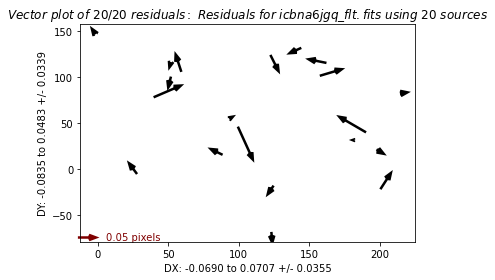

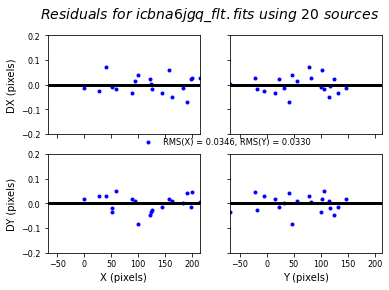

In [5]:
refcat = 'gaia.cat'
if camera=="UVO":
    cw = 3.5  # Set to two times the FWHM of the PSF.
    thresh=1000.
else:
    cw = 2.5
    thresh=100.
wcsname = 'Gaia'  # Specify the WCS name for this alignment
print(camera,cw)

for im in glob.glob("*"+kind+".fits"):
    if not os.path.exists(im[:-5]+".orig.fits"):
        shutil.copy(im,im[:-5]+".orig.fits")
    
tweakreg.TweakReg('*'+kind+'.fits',  # Pass input images
                  updatehdr=True,  # update header with new WCS solution
                  imagefindcfg={'threshold':thresh,'conv_width':cw},  # Detection parameters, threshold varies for different data
                  refcat=refcat,  # Use user supplied catalog (Gaia)
                  interactive=False,
                  see2dplot=False,
                  shiftfile=True,  # Save out shift file (so we can look at shifts later)
                  outshifts='Gaia_shifts.txt',  # name of the shift file
                  wcsname=wcsname,  # Give our WCS a new name
                  reusename=True,
                  sigma=2.3,
                  ylimit=0.2,
                  fitgeometry='general')  # Use the 6 parameter fit



In [6]:
for line in open('Gaia_shifts.txt').readlines():
    print(line)

# frame: output

# refimage: shifts_wcs.fits[wcs]

# form: delta

# units: pixels

icbna6jqq_flt.fits    0.055653  0.146460    0.002313     0.999944   0.038760  0.028384

icbna6jaq_flt.fits    0.084297  0.135939    359.992711     0.999905   0.042001  0.037525

icbna6jjq_flt.fits    0.005357  0.216487    0.017204     1.000060   0.039614  0.018404

icbna6jgq_flt.fits    0.021173  0.151803    359.997788     1.000020   0.034592  0.033031



In [7]:
# we have 4 exposures of ~same etime, so mosaic them all
astrodrizzle.AstroDrizzle('*'+kind+'.fits', 
                          output=filt,
                          preserve=False,
                          clean=True, 
                          build=False,
                          context=False,
                          skymethod='match',
                          driz_sep_bits='64, 32',
                          combine_type='minmed',
                          final_bits='64, 32')

INFO:drizzlepac.util:Setting up logfile :  astrodrizzle.log


Setting up logfile :  astrodrizzle.log


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 3.1.6 (2020-02-19 16:16:30 -0500) started at: 13:53:36.63 (17/06/2021)


AstroDrizzle Version 3.1.6 (2020-02-19 16:16:30 -0500) started at: 13:53:36.63 (17/06/2021)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:Version Information
INFO:drizzlepac.astrodrizzle:--------------------
INFO:drizzlepac.astrodrizzle:Python Version [Clang 10.0.0 ]
INFO:drizzlepac.astrodrizzle:3.7.10 (default, Feb 26 2021, 10:16:00) 
INFO:drizzlepac.astrodrizzle:numpy Version -> 1.20.2 
INFO:drizzlepac.astrodrizzle:astropy Version -> 4.2.1 
INFO:drizzlepac.astrodrizzle:stwcs Version -> 1.6.1 
INFO:drizzlepac.util:==== Processing Step  Initialization  started at  13:53:36.673 (17/06/2021)


==== Processing Step  Initialization  started at  13:53:36.673 (17/06/2021)


INFO:drizzlepac.util:


INFO:drizzlepac.processInput:Executing serially
INFO:drizzlepac.processInput:Setting up output name: f160w_drz.fits
INFO:drizzlepac.processInput:-Creating imageObject List as input for processing steps.
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0382167868850265
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.05121742099581331
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.08123638928624426
INFO:drizzlepac.imageObject:No context image will be created for icbna6jaq_flt.fits
INFO:drizzlepac.imageObject:No context image will be created for icbna6jgq_flt.fits
INFO:drizzlepac.imageObject:No context image will be created for icbna6jjq_flt.fits
INFO:drizzlepac.imageObject:No context image will be created for icbna6jqq_flt.fits
INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in icbna6jaq_flt.fits[DQ,1]
INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in icbna6jgq_flt.fits[DQ,1]
INFO

WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 85.26144911427555  -69.80411782544348  


CRVAL : 85.26144911427555  -69.80411782544348  


INFO:astropy.wcs.wcs:CRPIX : 542.5  483.5  


CRPIX : 542.5  483.5  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : -2.0428236686851746e-05  -2.9186089623147128e-05  


CD1_1 CD1_2  : -2.0428236686851746e-05  -2.9186089623147128e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -2.9186089623147128e-05  2.0428236686851746e-05  


CD2_1 CD2_2  : -2.9186089623147128e-05  2.0428236686851746e-05  


INFO:astropy.wcs.wcs:NAXIS : 1085  967


NAXIS : 1085  967


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:*  Estimated memory usage:  up to 79 Mb.


*  Estimated memory usage:  up to 79 Mb.


INFO:drizzlepac.processInput:*  Output image size:       1085 X 967 pixels. 


*  Output image size:       1085 X 967 pixels. 


INFO:drizzlepac.processInput:*  Output image file:       ~ 12 Mb. 


*  Output image file:       ~ 12 Mb. 


INFO:drizzlepac.processInput:*  Cores available:         4


*  Cores available:         4


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.util:==== Processing Step Initialization finished at 13:53:37.840 (17/06/2021)


==== Processing Step Initialization finished at 13:53:37.840 (17/06/2021)


INFO:drizzlepac.astrodrizzle:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.astrodrizzle:	build :	False
INFO:drizzlepac.astrodrizzle:	coeffs :	True
INFO:drizzlepac.astrodrizzle:	context :	False
INFO:drizzlepac.astrodrizzle:	crbit :	4096
INFO:drizzlepac.astrodrizzle:	group :	
INFO:drizzlepac.astrodrizzle:	in_memory :	False
INFO:drizzlepac.astrodrizzle:	input :	*flt.fits
INFO:drizzlepac.astrodrizzle:	mdriztab :	False
INFO:drizzlepac.astrodrizzle:	num_cores :	None
INFO:drizzlepac.astrodrizzle:	output :	f160w
INFO:drizzlepac.astrodrizzle:	proc_unit :	native
INFO:drizzlepac.astrodrizzle:	resetbits :	4096
INFO:drizzlepac.astrodrizzle:	runfile :	astrodrizzle.log
INFO:drizzlepac.astrodrizzle:	stepsize :	10
INFO:drizzlepac.astrodrizzle:	updatewcs :	False
INFO:drizzlepac.astrodrizzle:	wcskey :	
INFO:drizzlepac.util:==== Processing Step  Static Mask  started at  13:53:37.868 (17/06/2021)


==== Processing Step  Static Mask  started at  13:53:37.868 (17/06/2021)


INFO:drizzlepac.util:


INFO:drizzlepac.staticMask:USER INPUT PARAMETERS for Static Mask Step:
INFO:drizzlepac.staticMask:	static :	True
INFO:drizzlepac.staticMask:	static_sig :	4.0
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode =  0.666426;   rms = 0.582460;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode =  0.705488;   rms = 0.583780;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode =  0.726251;   rms = 0.578016;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode =  0.769182;   rms = 0.605507;   static_sig = 4.00
INFO:drizzlepac.staticMask:Saving static mask to disk: ./WFC3IR_1014x1014_1_staticMask.fits
INFO:drizzlepac.util:==== Processing Step Static Mask finished at 13:53:38.093 (17/06/2021)


==== Processing Step Static Mask finished at 13:53:38.093 (17/06/2021)


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  started at  13:53:38.098 (17/06/2021)


==== Processing Step  Subtract Sky  started at  13:53:38.098 (17/06/2021)


INFO:drizzlepac.util:


INFO:drizzlepac.sky:USER INPUT PARAMETERS for Sky Subtraction Step:
INFO:drizzlepac.sky:	sky_bits :	0
INFO:drizzlepac.sky:	skyclip :	5
INFO:drizzlepac.sky:	skyfile :	
INFO:drizzlepac.sky:	skylower :	None
INFO:drizzlepac.sky:	skylsigma :	4.0
INFO:drizzlepac.sky:	skymask_cat :	
INFO:drizzlepac.sky:	skymethod :	match
INFO:drizzlepac.sky:	skystat :	median
INFO:drizzlepac.sky:	skysub :	True
INFO:drizzlepac.sky:	skyupper :	None
INFO:drizzlepac.sky:	skyuser :	
INFO:drizzlepac.sky:	skyusigma :	4.0
INFO:drizzlepac.sky:	skywidth :	0.1
INFO:drizzlepac.sky:	use_static :	True
INFO:stsci.skypac.utils:***** skymatch started on 2021-06-17 13:53:38.267374


***** skymatch started on 2021-06-17 13:53:38.267374


INFO:stsci.skypac.utils:      Version 1.0.5


      Version 1.0.5


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:'skymatch' task will apply computed sky differences to input image file(s).


'skymatch' task will apply computed sky differences to input image file(s).


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


INFO:stsci.skypac.utils:'MDRIZSKY' header keyword will represent sky value *computed* from data.


'MDRIZSKY' header keyword will represent sky value *computed* from data.


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  User specified keywords:  -----


-----  User specified keywords:  -----


INFO:stsci.skypac.utils:       Sky Value Keyword:  'MDRIZSKY'


       Sky Value Keyword:  'MDRIZSKY'


INFO:stsci.skypac.utils:       Data Units Keyword: 'BUNIT'


       Data Units Keyword: 'BUNIT'


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Input file list:  -----


-----  Input file list:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'icbna6jaq_flt.fits'


   **  Input image: 'icbna6jaq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: icbna6jaq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: icbna6jaq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'icbna6jgq_flt.fits'


   **  Input image: 'icbna6jgq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: icbna6jgq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: icbna6jgq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'icbna6jjq_flt.fits'


   **  Input image: 'icbna6jjq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: icbna6jjq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: icbna6jjq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'icbna6jqq_flt.fits'


   **  Input image: 'icbna6jqq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: icbna6jqq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: icbna6jqq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Sky statistics parameters:  -----


-----  Sky statistics parameters:  -----


INFO:stsci.skypac.utils:       statistics function: 'median'


       statistics function: 'median'


INFO:stsci.skypac.utils:       lower = None


       lower = None


INFO:stsci.skypac.utils:       upper = None


       upper = None


INFO:stsci.skypac.utils:       nclip = 5


       nclip = 5


INFO:stsci.skypac.utils:       lsigma = 4.0


       lsigma = 4.0


INFO:stsci.skypac.utils:       usigma = 4.0


       usigma = 4.0


INFO:stsci.skypac.utils:       binwidth = 0.1


       binwidth = 0.1


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Data->Brightness conversion parameters for input files:  -----


-----  Data->Brightness conversion parameters for input files:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: icbna6jaq_flt.fits


   *   Image: icbna6jaq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: icbna6jgq_flt.fits


   *   Image: icbna6jgq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: icbna6jjq_flt.fits


   *   Image: icbna6jjq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: icbna6jqq_flt.fits


   *   Image: icbna6jqq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Computing differences in sky values in overlapping regions:  -----


-----  Computing differences in sky values in overlapping regions:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'icbna6jaq_flt.fits['SCI',1]' SKY = 0 [brightness units]


   *   Image 'icbna6jaq_flt.fits['SCI',1]' SKY = 0 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'icbna6jgq_flt.fits['SCI',1]' SKY = 2.492 [brightness units]


   *   Image 'icbna6jgq_flt.fits['SCI',1]' SKY = 2.492 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0409886


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0409886


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'icbna6jjq_flt.fits['SCI',1]' SKY = 3.53865 [brightness units]


   *   Image 'icbna6jjq_flt.fits['SCI',1]' SKY = 3.53865 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.058204


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.058204


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'icbna6jqq_flt.fits['SCI',1]' SKY = 5.18923 [brightness units]


   *   Image 'icbna6jqq_flt.fits['SCI',1]' SKY = 5.18923 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0853529


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0853529


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:***** skymatch ended on 2021-06-17 13:53:43.915864


***** skymatch ended on 2021-06-17 13:53:43.915864


INFO:stsci.skypac.utils:TOTAL RUN TIME: 0:00:05.648490


TOTAL RUN TIME: 0:00:05.648490


INFO:drizzlepac.util:==== Processing Step Subtract Sky finished at 13:53:44.055 (17/06/2021)


==== Processing Step Subtract Sky finished at 13:53:44.055 (17/06/2021)


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  started at  13:53:44.057 (17/06/2021)


==== Processing Step  Separate Drizzle  started at  13:53:44.057 (17/06/2021)


INFO:drizzlepac.util:


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=True as:
{'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'kernel': 'turbo', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'bits': 96, 'compress': False, 'units': 'cps'}
INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Separate Drizzle Step:
INFO:drizzlepac.adrizzle:	bits :	96
INFO:drizzlepac.adrizzle:	build :	False
INFO:drizzlepac.adrizzle:	clean :	True
INFO:drizzlepac.adrizzle:	coeffs :	True
INFO:drizzlepac.adrizzle:	compress :	False
INFO:drizzlepac.adrizzle:	crbit :	None
INFO:drizzlepac.adrizzle:	fillval :	None
INFO:drizzlepac.adrizzle:	kernel :	turbo
INFO:drizzlepac.adrizzle:	num_cores :	None
INFO:drizzlepac.adrizzle:	pixfrac :	1.0
INFO:drizzlepac.adrizzle:	proc_unit :	electrons
INFO:drizzlepac.adrizzle:	stepsize :	10
INFO:drizzlepac.adrizzle:	units :	cps
INFO:drizzlepac.adrizzle:	wcskey :	
INFO:drizzlepac.adrizzle:	wht_type :	None
INFO:drizzlepac.adrizzle:	wt_scl :	exptime
INFO:drizzlepac.adrizzle: 

WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 85.26144911427555  -69.80411782544348  


CRVAL : 85.26144911427555  -69.80411782544348  


INFO:astropy.wcs.wcs:CRPIX : 542.5  483.5  


CRPIX : 542.5  483.5  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : -2.0428236686851746e-05  -2.9186089623147128e-05  


CD1_1 CD1_2  : -2.0428236686851746e-05  -2.9186089623147128e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -2.9186089623147128e-05  2.0428236686851746e-05  


CD2_1 CD2_2  : -2.9186089623147128e-05  2.0428236686851746e-05  


INFO:astropy.wcs.wcs:NAXIS : 1085  967


NAXIS : 1085  967


INFO:drizzlepac.adrizzle:Executing 4 parallel workers
INFO:drizzlepac.adrizzle:-Drizzle input: icbna6jaq_flt.fits[sci,1]
INFO:drizzlepac.adrizzle:-Drizzle input: icbna6jgq_flt.fits[sci,1]
INFO:drizzlepac.adrizzle:-Drizzle input: icbna6jjq_flt.fits[sci,1]
INFO:drizzlepac.adrizzle:-Drizzle input: icbna6jqq_flt.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 0.058204 to icbna6jjq_flt.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 0.085353 to icbna6jqq_flt.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 0.040989 to icbna6jgq_flt.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 0.000000 to icbna6jaq_flt.fits[sci,1]
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.cdriz:-Drizzling using kernel = turbo

INFO:drizzlepac.adrizzle:

-Generating simple FITS output: icbna6jaq_single_sci.fits
-Generating simple FITS output: icbna6jgq_single_sci.fits


INFO:drizzlepac.outputimage:-Generating simple FITS output: icbna6jjq_single_sci.fits


-Generating simple FITS output: icbna6jjq_single_sci.fits
-Generating simple FITS output: icbna6jqq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: icbna6jaq_single_sci.fits


Writing out image to disk: icbna6jaq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: icbna6jgq_single_sci.fits
INFO:drizzlepac.outputimage:Writing out image to disk: icbna6jjq_single_sci.fits


Writing out image to disk: icbna6jgq_single_sci.fits
Writing out image to disk: icbna6jjq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: icbna6jqq_single_sci.fits


Writing out image to disk: icbna6jqq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: icbna6jgq_single_wht.fits
INFO:drizzlepac.outputimage:Writing out image to disk: icbna6jaq_single_wht.fits


Writing out image to disk: icbna6jgq_single_wht.fits
Writing out image to disk: icbna6jaq_single_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: icbna6jjq_single_wht.fits
INFO:drizzlepac.outputimage:Writing out image to disk: icbna6jqq_single_wht.fits


Writing out image to disk: icbna6jqq_single_wht.fits
Writing out image to disk: icbna6jjq_single_wht.fits


INFO:drizzlepac.util:==== Processing Step Separate Drizzle finished at 13:53:45.368 (17/06/2021)


==== Processing Step Separate Drizzle finished at 13:53:45.368 (17/06/2021)


INFO:drizzlepac.util:==== Processing Step  Create Median  started at  13:53:45.372 (17/06/2021)


==== Processing Step  Create Median  started at  13:53:45.372 (17/06/2021)


INFO:drizzlepac.util:


INFO:drizzlepac.createMedian:USER INPUT PARAMETERS for Create Median Step:
INFO:drizzlepac.createMedian:	combine_bufsize :	None
INFO:drizzlepac.createMedian:	combine_grow :	1
INFO:drizzlepac.createMedian:	combine_hthresh :	None
INFO:drizzlepac.createMedian:	combine_lthresh :	None
INFO:drizzlepac.createMedian:	combine_maskpt :	0.3
INFO:drizzlepac.createMedian:	combine_nhigh :	0
INFO:drizzlepac.createMedian:	combine_nlow :	0
INFO:drizzlepac.createMedian:	combine_nsigma :	4 3
INFO:drizzlepac.createMedian:	combine_type :	minmed
INFO:drizzlepac.createMedian:	compress :	False
INFO:drizzlepac.createMedian:	median :	True
INFO:drizzlepac.createMedian:	median_newmasks :	True
INFO:drizzlepac.createMedian:	proc_unit :	native
INFO:drizzlepac.createMedian:reference sky value for image 'icbna6jaq_flt.fits' is 0.0


reference sky value for image 'icbna6jaq_flt.fits' is 0.0


INFO:drizzlepac.createMedian:reference sky value for image 'icbna6jgq_flt.fits' is 16.363941677089944


reference sky value for image 'icbna6jgq_flt.fits' is 16.363941677089944


INFO:drizzlepac.createMedian:reference sky value for image 'icbna6jjq_flt.fits' is 23.236865056905717


reference sky value for image 'icbna6jjq_flt.fits' is 23.236865056905717


INFO:drizzlepac.createMedian:reference sky value for image 'icbna6jqq_flt.fits' is 25.5402423962792


reference sky value for image 'icbna6jqq_flt.fits' is 25.5402423962792


INFO:drizzlepac.createMedian:Saving output median image to: 'f160w_med.fits'


Saving output median image to: 'f160w_med.fits'


INFO:drizzlepac.util:==== Processing Step Create Median finished at 13:53:46.179 (17/06/2021)


==== Processing Step Create Median finished at 13:53:46.179 (17/06/2021)


INFO:drizzlepac.util:==== Processing Step  Blot  started at  13:53:46.181 (17/06/2021)


==== Processing Step  Blot  started at  13:53:46.181 (17/06/2021)


INFO:drizzlepac.util:


INFO:drizzlepac.ablot:USER INPUT PARAMETERS for Blot Step:
INFO:drizzlepac.ablot:	blot_addsky :	True
INFO:drizzlepac.ablot:	blot_interp :	poly5
INFO:drizzlepac.ablot:	blot_sinscl :	1.0
INFO:drizzlepac.ablot:	blot_skyval :	0.0
INFO:drizzlepac.ablot:	coeffs :	True
INFO:drizzlepac.ablot:    Blot: creating blotted image:  icbna6jaq_flt.fits[sci,1]


    Blot: creating blotted image:  icbna6jaq_flt.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 0.000000 to blotted image icbna6jaq_flt.fits[sci,1]
INFO:drizzlepac.outputimage:-Generating simple FITS output: icbna6jaq_sci1_blt.fits


-Generating simple FITS output: icbna6jaq_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: icbna6jaq_sci1_blt.fits


Writing out image to disk: icbna6jaq_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  icbna6jgq_flt.fits[sci,1]


    Blot: creating blotted image:  icbna6jgq_flt.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 0.040989 to blotted image icbna6jgq_flt.fits[sci,1]
INFO:drizzlepac.outputimage:-Generating simple FITS output: icbna6jgq_sci1_blt.fits


-Generating simple FITS output: icbna6jgq_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: icbna6jgq_sci1_blt.fits


Writing out image to disk: icbna6jgq_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  icbna6jjq_flt.fits[sci,1]


    Blot: creating blotted image:  icbna6jjq_flt.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 0.058204 to blotted image icbna6jjq_flt.fits[sci,1]
INFO:drizzlepac.outputimage:-Generating simple FITS output: icbna6jjq_sci1_blt.fits


-Generating simple FITS output: icbna6jjq_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: icbna6jjq_sci1_blt.fits


Writing out image to disk: icbna6jjq_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  icbna6jqq_flt.fits[sci,1]


    Blot: creating blotted image:  icbna6jqq_flt.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 0.085353 to blotted image icbna6jqq_flt.fits[sci,1]
INFO:drizzlepac.outputimage:-Generating simple FITS output: icbna6jqq_sci1_blt.fits


-Generating simple FITS output: icbna6jqq_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: icbna6jqq_sci1_blt.fits


Writing out image to disk: icbna6jqq_sci1_blt.fits


INFO:drizzlepac.util:==== Processing Step Blot finished at 13:53:48.216 (17/06/2021)


==== Processing Step Blot finished at 13:53:48.216 (17/06/2021)


INFO:drizzlepac.util:==== Processing Step  Driz_CR  started at  13:53:48.218 (17/06/2021)


==== Processing Step  Driz_CR  started at  13:53:48.218 (17/06/2021)


INFO:drizzlepac.util:


INFO:drizzlepac.drizCR:USER INPUT PARAMETERS for Driz_CR Step:
INFO:drizzlepac.drizCR:	crbit :	4096
INFO:drizzlepac.drizCR:	driz_cr :	True
INFO:drizzlepac.drizCR:	driz_cr_corr :	False
INFO:drizzlepac.drizCR:	driz_cr_ctegrow :	0
INFO:drizzlepac.drizCR:	driz_cr_grow :	1
INFO:drizzlepac.drizCR:	driz_cr_scale :	1.2 0.7
INFO:drizzlepac.drizCR:	driz_cr_snr :	3.5 3.0
INFO:drizzlepac.drizCR:	inmemory :	False
INFO:drizzlepac.drizCR:Executing 4 parallel workers
INFO:drizzlepac.drizCR:Creating output: icbna6jgq_sci1_crmask.fits


Creating output: icbna6jgq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output: icbna6jjq_sci1_crmask.fits


Creating output: icbna6jjq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output: icbna6jaq_sci1_crmask.fits


Creating output: icbna6jaq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output: icbna6jqq_sci1_crmask.fits


Creating output: icbna6jqq_sci1_crmask.fits


INFO:drizzlepac.util:==== Processing Step Driz_CR finished at 13:53:49.46 (17/06/2021)


==== Processing Step Driz_CR finished at 13:53:49.46 (17/06/2021)


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  started at  13:53:49.485 (17/06/2021)


==== Processing Step  Final Drizzle  started at  13:53:49.485 (17/06/2021)


INFO:drizzlepac.util:


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=False as:
{'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'wht_type': 'EXP', 'kernel': 'square', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'maskval': None, 'bits': 96, 'units': 'cps'}
INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Final Drizzle Step:
INFO:drizzlepac.adrizzle:	bits :	96
INFO:drizzlepac.adrizzle:	build :	False
INFO:drizzlepac.adrizzle:	clean :	True
INFO:drizzlepac.adrizzle:	coeffs :	True
INFO:drizzlepac.adrizzle:	crbit :	4096
INFO:drizzlepac.adrizzle:	fillval :	None
INFO:drizzlepac.adrizzle:	kernel :	square
INFO:drizzlepac.adrizzle:	maskval :	None
INFO:drizzlepac.adrizzle:	pixfrac :	1.0
INFO:drizzlepac.adrizzle:	proc_unit :	native
INFO:drizzlepac.adrizzle:	stepsize :	10
INFO:drizzlepac.adrizzle:	units :	cps
INFO:drizzlepac.adrizzle:	wcskey :	
INFO:drizzlepac.adrizzle:	wht_type :	EXP
INFO:drizzlepac.adrizzle:	wt_scl :	exptime
INFO:drizzlepac.adrizzle:  **Using sub-sampling value of 1

WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 85.26144911427555  -69.80411782544348  


CRVAL : 85.26144911427555  -69.80411782544348  


INFO:astropy.wcs.wcs:CRPIX : 542.5  483.5  


CRPIX : 542.5  483.5  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : -2.0428236686851746e-05  -2.9186089623147128e-05  


CD1_1 CD1_2  : -2.0428236686851746e-05  -2.9186089623147128e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -2.9186089623147128e-05  2.0428236686851746e-05  


CD2_1 CD2_2  : -2.9186089623147128e-05  2.0428236686851746e-05  


INFO:astropy.wcs.wcs:NAXIS : 1085  967


NAXIS : 1085  967


INFO:drizzlepac.adrizzle:-Drizzle input: icbna6jaq_flt.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 0.000000 to icbna6jaq_flt.fits[sci,1]
INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = square

INFO:drizzlepac.adrizzle:-Drizzle input: icbna6jgq_flt.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 0.040989 to icbna6jgq_flt.fits[sci,1]
INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = square

INFO:drizzlepac.adrizzle:-Drizzle input: icbna6jjq_flt.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 0.058204 to icbna6jjq_flt.fits[sci,1]
INFO:drizzlepac.imageObject:Applying EXPTIME weighting

-Generating simple FITS output: f160w_drz_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: f160w_drz_sci.fits


Writing out image to disk: f160w_drz_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: f160w_drz_wht.fits


Writing out image to disk: f160w_drz_wht.fits


INFO:drizzlepac.util:==== Processing Step Final Drizzle finished at 13:53:52.716 (17/06/2021)


==== Processing Step Final Drizzle finished at 13:53:52.716 (17/06/2021)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 3.1.6 is finished processing at 13:53:52.724 (17/06/2021).


AstroDrizzle Version 3.1.6 is finished processing at 13:53:52.724 (17/06/2021).


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.util:


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:                   Step          Elapsed time


                   Step          Elapsed time


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:


INFO:drizzlepac.util:         Initialization          1.1664 sec.


         Initialization          1.1664 sec.


INFO:drizzlepac.util:            Static Mask          0.2250 sec.


            Static Mask          0.2250 sec.


INFO:drizzlepac.util:           Subtract Sky          5.9567 sec.


           Subtract Sky          5.9567 sec.


INFO:drizzlepac.util:       Separate Drizzle          1.3109 sec.


       Separate Drizzle          1.3109 sec.


INFO:drizzlepac.util:          Create Median          0.8072 sec.


          Create Median          0.8072 sec.


INFO:drizzlepac.util:                   Blot          2.0353 sec.


                   Blot          2.0353 sec.


INFO:drizzlepac.util:                Driz_CR          1.2485 sec.


                Driz_CR          1.2485 sec.


INFO:drizzlepac.util:          Final Drizzle          3.2311 sec.


          Final Drizzle          3.2311 sec.


INFO:drizzlepac.util:   ====================          ====================


   ====================          ====================


INFO:drizzlepac.util:                  Total          15.9812 sec.


                  Total          15.9812 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.imageObject:Removing intermediate files for icbna6jaq_flt.fits
INFO:drizzlepac.imageObject:Removing intermediate files for icbna6jgq_flt.fits
INFO:drizzlepac.imageObject:Removing intermediate files for icbna6jjq_flt.fits
INFO:drizzlepac.imageObject:Removing intermediate files for icbna6jqq_flt.fits
INFO:drizzlepac.util:Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log


IR


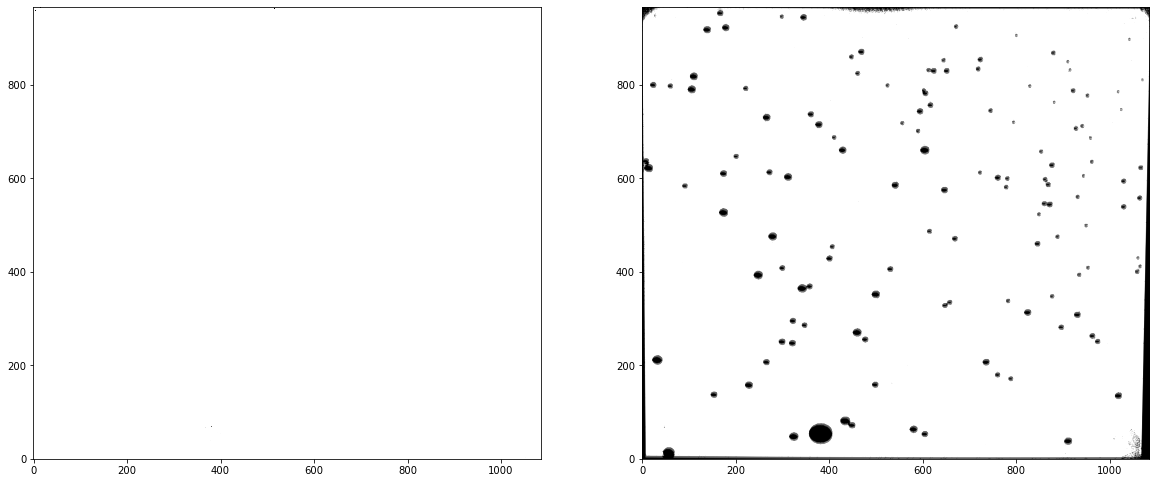

In [8]:
if camera=="UVO":
    sci = fits.getdata(filt+'_drc_sci.fits')
    wht = fits.getdata(filt+'_drc_wht.fits')
else:
    sci = fits.getdata(filt+'_drz_sci.fits')
    wht = fits.getdata(filt+'_drz_wht.fits')
print(camera)

fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.imshow(sci, vmin=-0.05, vmax=0.4, cmap='Greys_r', origin='lower')
ax2.imshow(wht, vmin=0, vmax=1000, cmap='Greys_r', origin='lower')

icbna6jqq_flt.fits
icbna6jqq_flt.orig.fits


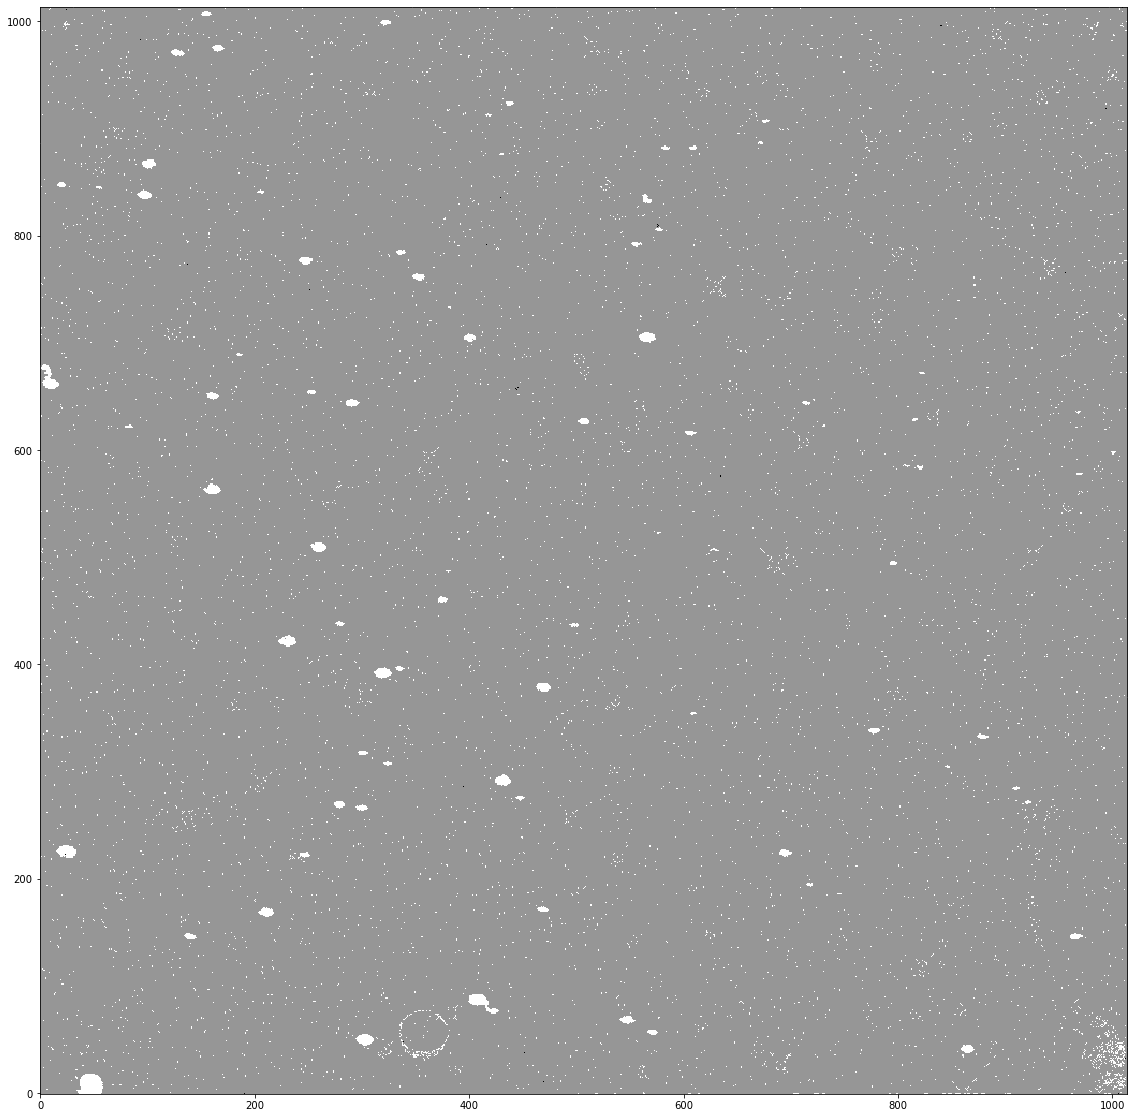

In [9]:
testim=glob.glob("*"+kind+".fits")[0]
# when this is first run, testim will have multiple extensions, and need to load X3 here
hdulist=fits.open(testim)
if len(hdulist)>3:
    print(testim)
    dq=fits.getdata(testim,3)
# however, later in the process, dolphot will have overwritten the fl[t|c] file into a single-extension file
# so we need to go get the saved "gaiareg.fits" file
else:
    print(testim[:-5]+".gaiareg.fits")
    dq=fits.getdata(testim[:-5]+".gaiareg.fits",3)

print(testim[:-5]+".orig.fits")
origdq=fits.getdata(testim[:-5]+".orig.fits",3)
fig = plt.figure(figsize=(20, 20))
#ax1 = fig.add_subplot(1, 2, 1)
#ax2 = fig.add_subplot(1, 2, 2)
ax2=fig.add_subplot(111)
#ax1.imshow(origdq, cmap='Greys_r', origin='lower')
ax2.imshow(dq-origdq, cmap='Greys_r', origin='lower',interpolation="nearest")